In [30]:
# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import time
import warnings
import os

# Preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

In [31]:
%matplotlib inline

# Customize matplotlib
mpl.rc("axes", labelsize=12, titlesize=14)
mpl.rc("figure", figsize=(8, 4))

# Customize seaborn
sns.set_style("darkgrid")
sns.set_palette("muted")

# Ignore warnings
warnings.filterwarnings("ignore")

# Set the decimal format
#pd.options.display.float_format = "{:.3f}".format

In [32]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e16/sample_submission.csv
/kaggle/input/playground-series-s3e16/train.csv
/kaggle/input/playground-series-s3e16/test.csv


In [33]:
train = pd.read_csv("/kaggle/input/playground-series-s3e16/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e16/test.csv")
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("")
train.head()

Train shape: (74051, 10)
Test shape: (49368, 9)



,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


# <b><span style="color: #bf4342">1 EDA</span></b>

In [34]:
def summary(df):
    """
    Function to summary missing, unique, and duplicate values. Takes the min and max as well.
    """
    summ = pd.DataFrame(df.dtypes, columns=["dtypes"])
    summ["#missing"] = df.isna().sum().values
    summ["%missing"] = np.round(100 * df.isna().sum().values / len(df), 2)
    summ["unique"] = df.nunique().values
    summ["min"] = df.min().values
    summ["max"] = df.max().values
    print(f"The dataset has {df.duplicated().sum()} duplicate values\n")
    
    return summ

In [35]:
summary(train)

The dataset has 0 duplicate values



,dtypes,#missing,%missing,unique,min,max
id,int64,0,0.0,74051,0,74050
Sex,object,0,0.0,3,F,M
Length,float64,0,0.0,144,0.1875,2.012815
Diameter,float64,0,0.0,122,0.1375,1.6125
Height,float64,0,0.0,65,0.0,2.825
Weight,float64,0,0.0,3096,0.056699,80.101512
Shucked Weight,float64,0,0.0,1766,0.028349,42.184056
Viscera Weight,float64,0,0.0,967,0.042524,21.54562
Shell Weight,float64,0,0.0,1048,0.042524,28.491248
Age,int64,0,0.0,28,1,29


In [36]:
summary(test)

The dataset has 0 duplicate values



,dtypes,#missing,%missing,unique,min,max
id,int64,0,0.0,49368,74051,123418
Sex,object,0,0.0,3,F,M
Length,float64,0,0.0,140,0.1875,2.0375
Diameter,float64,0,0.0,122,0.1375,1.625
Height,float64,0,0.0,57,0.0,2.825
Weight,float64,0,0.0,2948,0.056699,80.101512
Shucked Weight,float64,0,0.0,1692,0.028349,42.184056
Viscera Weight,float64,0,0.0,938,0.014175,21.54562
Shell Weight,float64,0,0.0,987,0.042524,28.491248


Notes:
- Both train and test sets have no missing values and no duplicates
- The data types are ok
- __Age__ is the target

In [37]:
train["Sex"].value_counts()

M    27084
I    23957
F    23010
Name: Sex, dtype: int64

There is no explanation for that "I", so we can imagine them as Indeterminate.

## <b><span style="color: #bf4342">1.1 Numerical features</span></b>

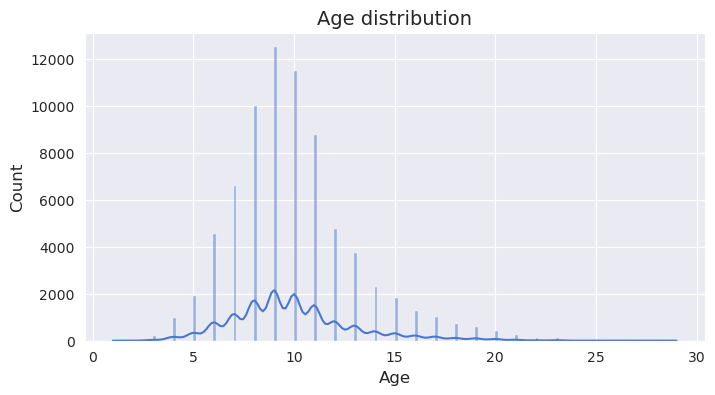

In [38]:
sns.histplot(data=train, x="Age", kde=True)
plt.title("Age distribution")

plt.show()

Notes:
- Most crabs in the train set have 9 years old
- The feature is right skewed, but with a small number of outliers

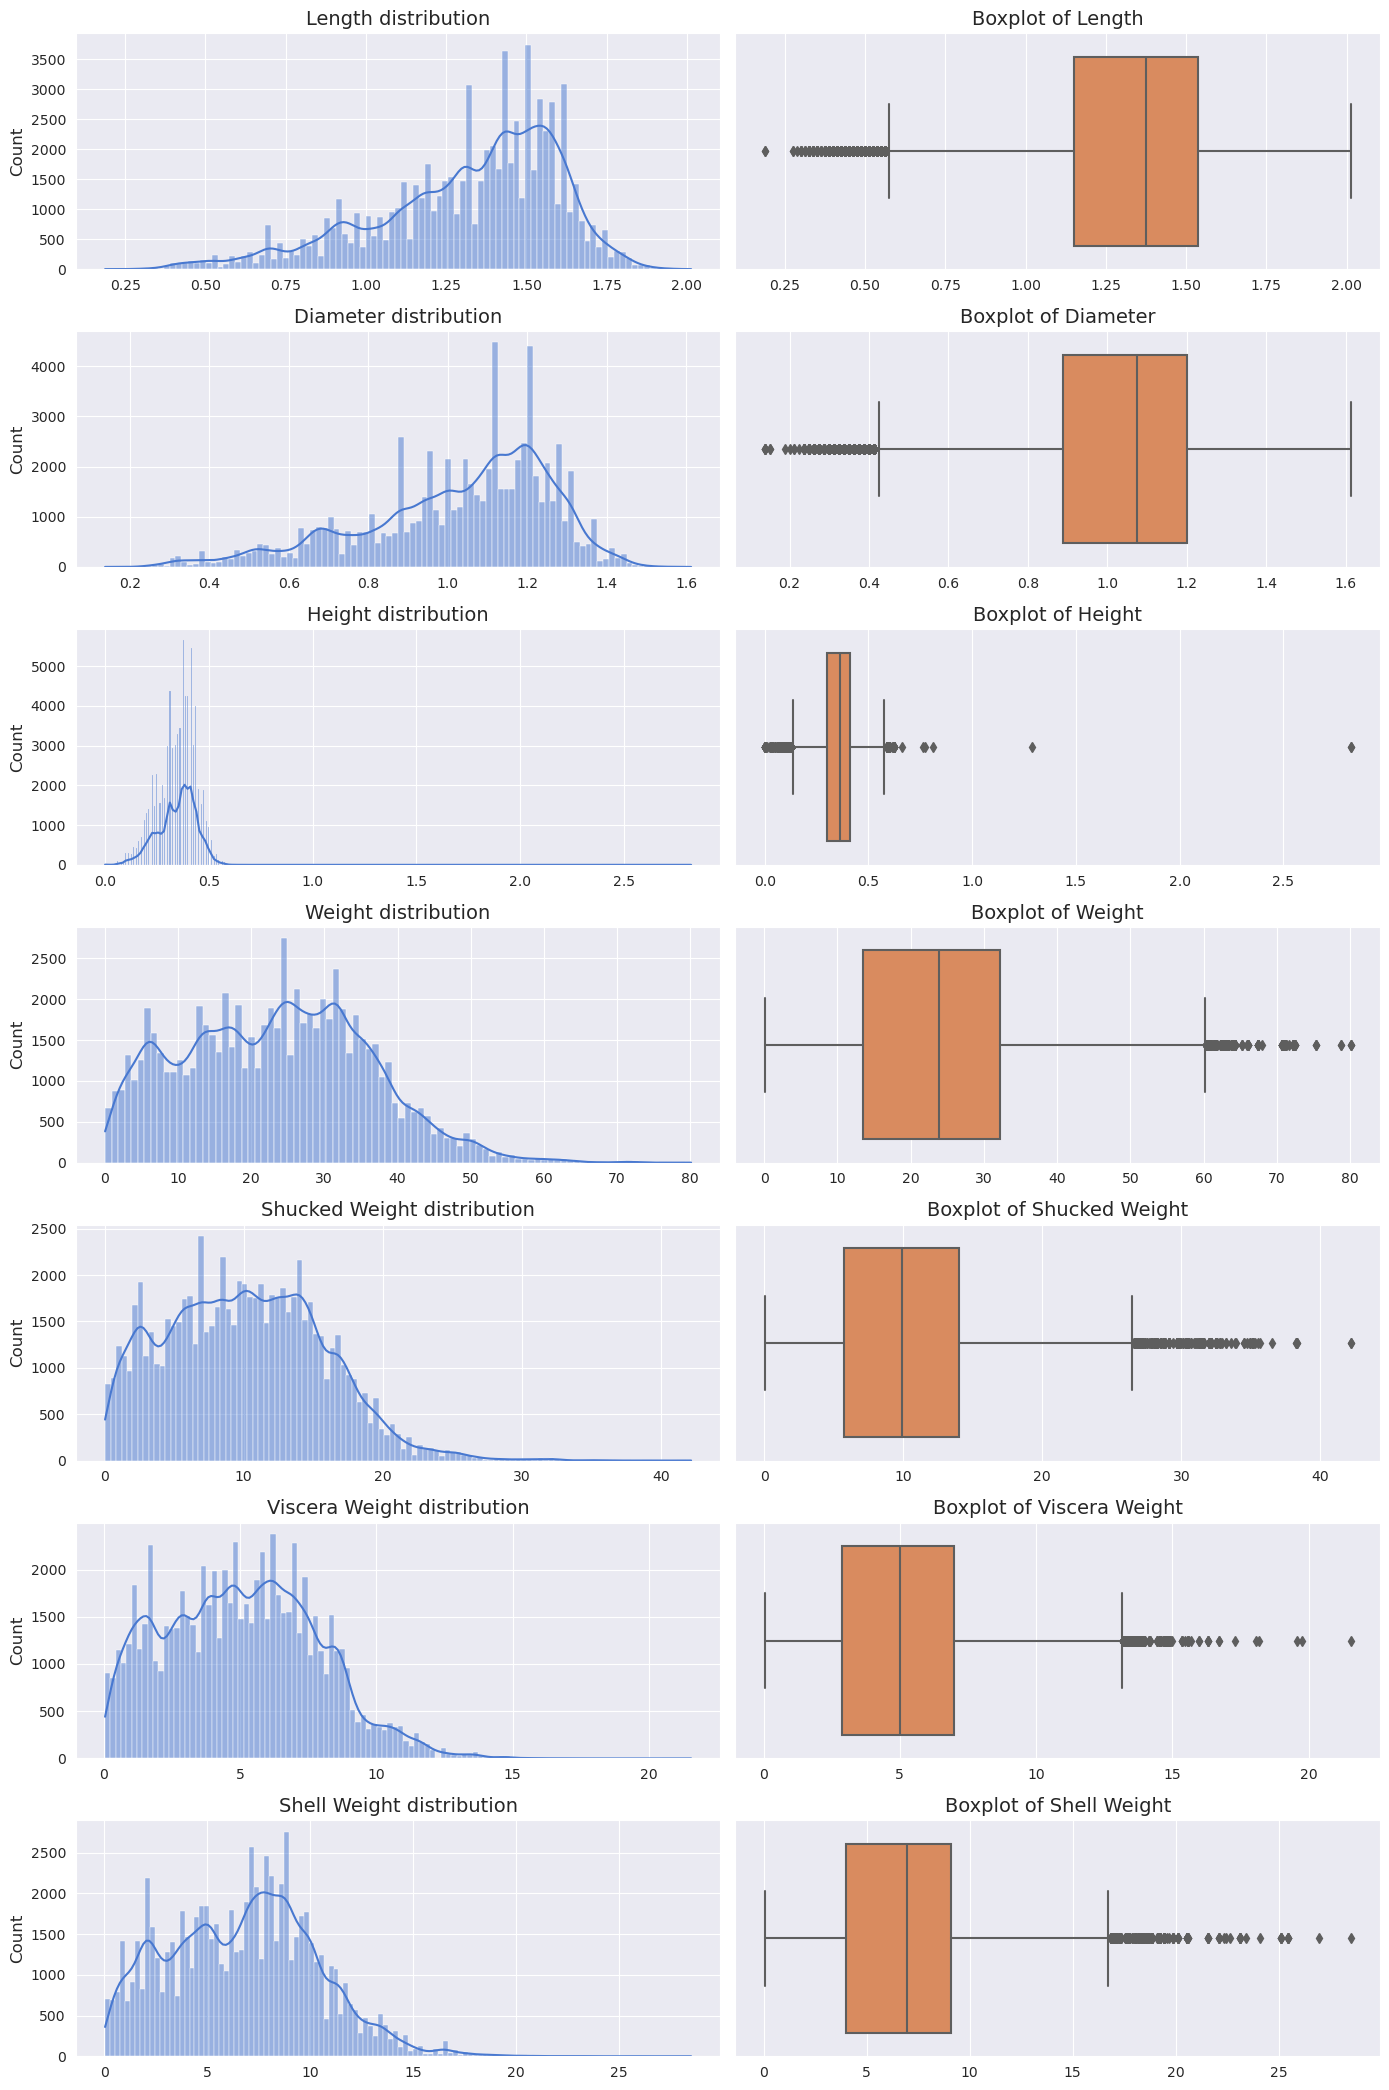

In [39]:
# Select continuous features
cont_cols = train.select_dtypes(exclude=["object", "int64"]).columns.tolist()

# Plot all features
fig = plt.figure(figsize=(14,len(cont_cols)*3))
for i, var_name in enumerate(cont_cols):
    fig.add_subplot(len(cont_cols), 2, 2*i+1)
    sns.histplot(data=train, x=var_name, kde=True)
    plt.title(f"{var_name} distribution")
    plt.xlabel("")
    
    fig.add_subplot(len(cont_cols), 2, 2*i+2)
    sns.boxplot(data=train, x=var_name, color="C1")
    plt.title(f"Boxplot of {var_name}")
    plt.xlabel("")
    
fig.tight_layout()
plt.show()

Notes:
- All continuous features have outliers
- __Height__ is quite skewed and has some rows with zero, which doesn't make sense

Insights:
- Replace 0 values with predicted values using <code>DecisionTreeRegressor</code>
- Try new features such as Height^2 or Volume

In [40]:
# train["df"] = 0
# test["df"] = 1

# # Concatenate train and test
# temp_df = pd.concat([train, test], ignore_index=True)

# # Find Height == 0
# h0 = temp_df.loc[temp_df["Height"] == 0] # Imagine it as X_test
# h1 = temp_df.loc[temp_df["Height"] != 0] # Imagine it as X

# # Split into X and Y
# x_h0 = h0.drop(["Height", "Sex", "Age"], axis=1)
# x_h1 = h1.drop(["Height", "Sex", "Age"], axis=1)
# y_h1 = h1["Height"]

# # Train and predict
# dtr = DecisionTreeRegressor(random_state=42) # Fast model
# dtr.fit(x_h1, y_h1)
# preds_height = dtr.predict(x_h0)

# # Replace 0 with predicted values
# temp_df.loc[temp_df["Height"] == 0, "Height"] = preds_height

# # Back into train and test
# train = temp_df.loc[temp_df["df"] == 0]
# train.reset_index(drop=True, inplace=True)
# train.drop("df", axis=1, inplace=True)

# test = temp_df.loc[temp_df["df"] == 1]
# test.drop("df", axis=1).reset_index(drop=True, inplace=True)
# test.drop("df", axis=1, inplace=True)

In [41]:
train = train.loc[(train["Height"] > 0) & (train["Height"] < 1.0)]

## <b><span style="color: #bf4342">1.2 Categorical features</span></b>

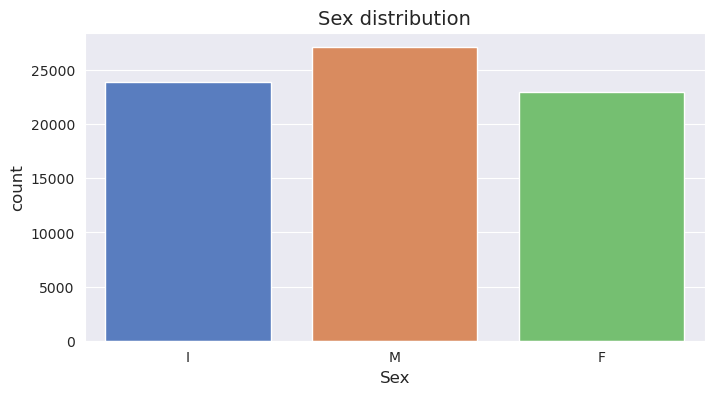

In [42]:
sns.countplot(data=train, x="Sex")
plt.title("Sex distribution")

plt.show()

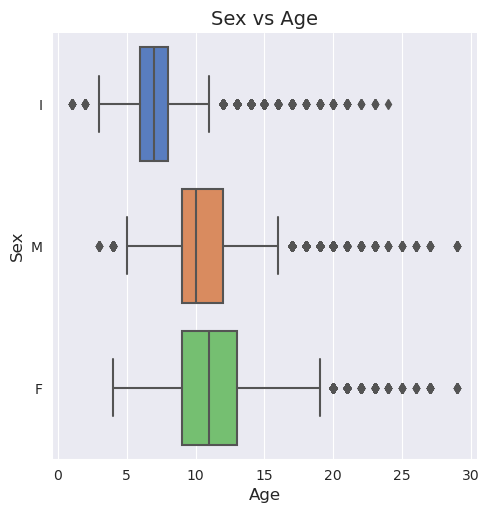

In [43]:
sns.catplot(data=train, x="Age", y="Sex", kind="box")
plt.title("Sex vs Age")

plt.show()

Notes:
- Sex feature are almost equally distributed
- Female crabs seem to live more

## <b><span style="color: #bf4342">1.3 Correlation matrix</span></b>

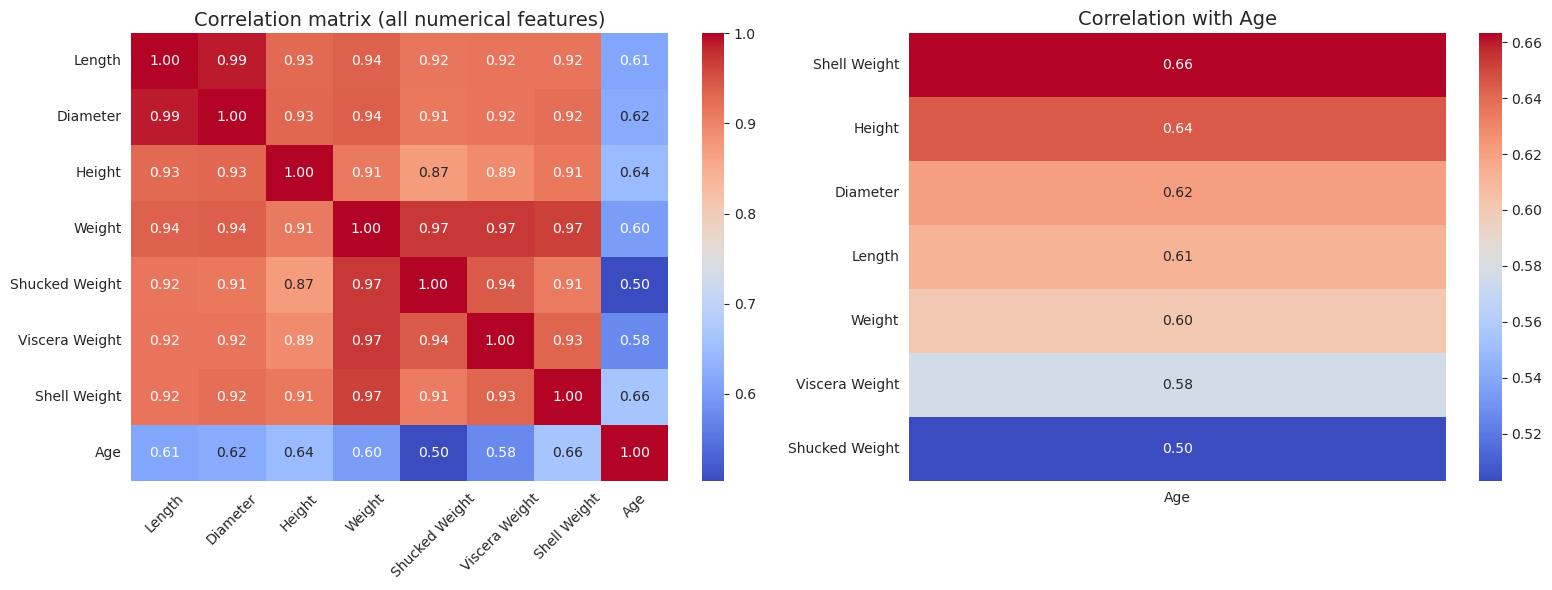

In [44]:
# Drop id
corr = train.drop("id", axis=1)

# Plot 
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.heatmap(corr.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation matrix (all numerical features)")
plt.xticks(rotation=45)

corr_sorted = corr.corr()["Age"].sort_values(ascending=False).to_frame()
plt.subplot(1, 2, 2)
sns.heatmap(corr_sorted.drop("Age"), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation with Age")

fig.tight_layout()

Notes:
- All continuous features are highly correlated with each other, which makes sense since all are related to physical characteristics
- The correlation with __Age__ is either moderate or strong (__Shell Weight__ and __Height__ are the stronger ones)

# <b><span style="color: #bf4342">2 Feature Engineering</span></b>

Some people said that __Weight__ can be smaller than the sum of all weight, which doesn't make sense. Let's see that.

In [45]:
(train[["Shucked Weight", "Viscera Weight", "Shell Weight"]].sum(axis=1) > train["Weight"]).astype(int).sum()

8928

Indeed, there are 8932 rows where __Total Weight__ is greater than __Weight__. Let's fix that.

Also, let's create some new features that might help our models out.

In [46]:
def new_features(df):
    # Fix Weight
    condition = df["Weight"] < df[["Shucked Weight", "Viscera Weight", "Shell Weight"]].sum(axis=1)
    new_value = df[["Shucked Weight", "Viscera Weight", "Shell Weight"]].sum(axis=1)
    df["Weight"] = np.where(condition, new_value, df["Weight"])
    
    # New Features -> credit to Gaurav Pandey here
    df["Viscera Ratio"] = df["Viscera Weight"] / df["Weight"]
    df["Shell Ratio"] = df["Shell Weight"] / df["Weight"]
#     df["Volume"] = df["Height"] * df["Length"] * df["Diameter"]
#     df["Density"] = df["Weight"] / df["Volume"]
    df["Diameter^2"] = df["Diameter"] ** 2
    df["Length^2"] = df["Length"] ** 2
    df["logHeight"] = np.log(1 + df["Height"])

    return df

train = new_features(train)
test = new_features(test)

# <b><span style="color: #bf4342">3 Preprocessing</span></b>

In [47]:
# Define y, X and X_test
X = train.drop(["id", "Age"], axis=1).copy()
y = train["Age"].copy()
X_test = test.drop("id", axis=1).copy()

In [48]:
# Retrieve numerical and categorical columns
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Pipeline
# Numerical features
#num_pipe = Pipeline(steps=[("scaler", StandardScaler())])
num_pipe = Pipeline(steps=[("scaler", MinMaxScaler())])

# Categorical features
cat_pipe = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))])

# ColumnTransformer
transformer = ColumnTransformer(transformers=[
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)],
    remainder="passthrough")

# Apply it
X = transformer.fit_transform(X)
X_test = transformer.transform(X_test)

# Shape
print("X shape:", X.shape)
print("X_test shape:", X_test.shape)

X shape: (74024, 15)
X_test shape: (49368, 15)


# <b><span style="color: #bf4342">4 Model selection</span></b>

In [49]:
seed = 42

Since the dataset has some outliers, we can specify the function to optimize (when available) as __Mean Absolute Error__.

In [50]:
models = {
    "LogisticRegression": LogisticRegression(random_state=seed),
    "LGBM": LGBMRegressor(random_state=seed, objective="mae"),
    "CatBoost": CatBoostRegressor(verbose=False, random_state=seed, loss_function="MAE"),
    "XGBoost": XGBRegressor(random_state=seed, objective="reg:absoluteerror"),
    "LinearSVR": LinearSVR(random_state=seed),
    #"RandomForest": RandomForestRegressor(random_state=seed), # takes too long
    "GradientBoosting": GradientBoostingRegressor(random_state=seed, loss="absolute_error")
}

## <b><span style="color: #bf4342">4.1 Cross-validation</span></b>

In [51]:
# Create a DataFrame to store results
cv_results = pd.DataFrame({"Model": models.keys(), "Mean CV MAE": np.empty(len(models)), "Mean CV RMSE": np.empty(len(models)),"Traning time (s)": np.empty(len(models))})

# Dict to store feature importances
importances = models.copy()
del importances["LogisticRegression"], importances["LinearSVR"]

# Number of folds
folds = 5

i = 0
print("Training time")
print(25*"-")
for key, model in models.items():
    
    # Start timer
    t0 = time.time()
    
    # 5 fold cross-validation
    cv = KFold(n_splits=folds, shuffle=True, random_state=seed)
    
    mae = 0
    mse = 0
    
    for (train_idx, val_idx) in cv.split(X, y):
        
        # Get train and validation sets
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train the model
        reg = model
        reg.fit(X_train, y_train)
        
        # Feature importance
        if key in ["LogisticRegression", "LinearSVR"]:
            pass
        else:
            # Store feature importances
            importances[key] = reg.feature_importances_
        
        # Make predictions and measures
        y_pred = reg.predict(X_val)
        mae += mean_absolute_error(y_val, y_pred)
        mse += np.sqrt(mean_squared_error(y_val, y_pred))
    
    # Store the mean MAE
    cv_results.iloc[i, 1] = mae/folds
    cv_results.iloc[i, 2] = mse/folds
    
    # Stop timer
    t1 = time.time()
    cv_results.iloc[i, 3] = np.round(t1 - t0, 2)
    
    # Print training time
    print(f"{key}:", cv_results.iloc[i, 3], "s")
    i +=1

Training time
-------------------------
LogisticRegression: 46.89 s
LGBM: 5.77 s
CatBoost: 58.03 s
XGBoost: 43.43 s
LinearSVR: 2.09 s
GradientBoosting: 79.64 s


In [52]:
cv_results

,Model,Mean CV MAE,Mean CV RMSE,Traning time (s)
0,LogisticRegression,1.526235,2.498407,46.89
1,LGBM,1.368693,2.118941,5.77
2,CatBoost,1.363624,2.094014,58.03
3,XGBoost,1.375470,2.101362,43.43
4,LinearSVR,1.429893,2.166940,2.09
5,GradientBoosting,1.422466,2.191840,79.64


## <b><span style="color: #bf4342">4.2 Feature importances</span></b>

The feature importance provides insights into which features are most influential when predicting __Age__.

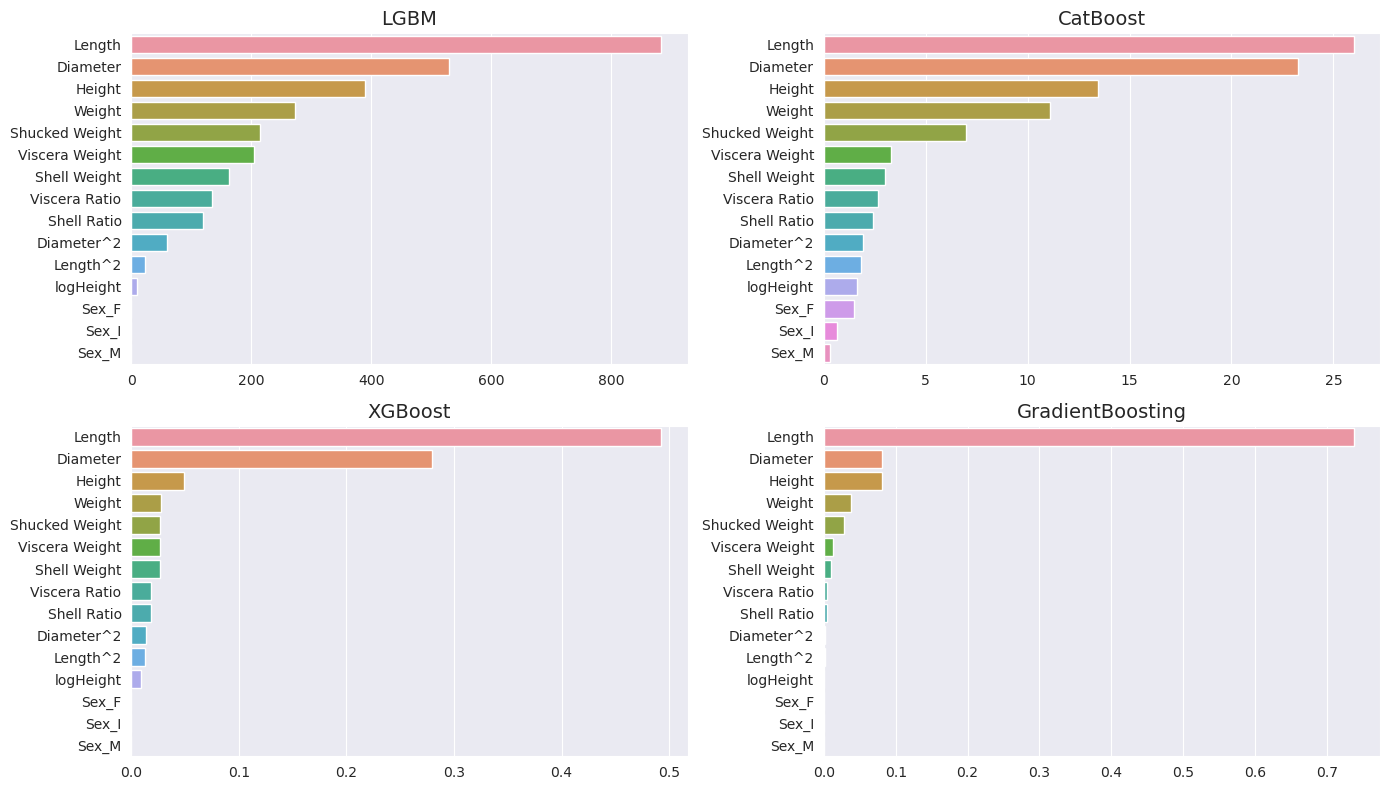

In [53]:
# Retrieve feature names
onehot_cols = transformer.named_transformers_["cat"].get_feature_names_out().tolist()
feature_names = num_cols + onehot_cols

importances_df = pd.DataFrame.from_dict(importances)
importances_df.index = feature_names

# Plot
fig = plt.figure(figsize=(14,len(importances_df.columns)*2))
for i, col in enumerate(importances_df.columns):
    fig.add_subplot(2, 2, 1*i+1)
    sns.barplot(data=importances_df.sort_values(by=col, ascending=False), x=col, y=importances_df.index)
    plt.xlabel(None)
    plt.title(col)
    
fig.tight_layout()
plt.show()

Notes:
- __Length__ is the most important feature for all models, followed by __Diameter__ and __Height__
- Related to the new features, only __Viscera Ratio__, __Shell Ratio__, and __Volume__ seem to have some importance
- __Sex__ and log features are basically useless

## <b><span style="color: #bf4342">4.3 Tuning hyperparameters</span></b>

LGBM, CatBoost, and XGBoost are the best models. We can take them to tune their hyperparameters.

In [54]:
# Best models
best_models = {
    "LGBM": LGBMRegressor(random_state=seed, objective = "mae"),
    "CatBoost": CatBoostRegressor(verbose=False, random_state=seed, loss_function="MAE"),
    #"XGBoost": XGBRegressor(random_state=seed, objective="reg:absoluteerror")
}

# Grid to search for
grid = {
    "LGBM": {"n_estimators": [50, 100, 150, 200],
             "max_depth": [4, 6, 8],
             "learning_rate": [0.05, 0.1, 0.15]},
    "CatBoost": {"iterations": [100, 200, 300],
                 "learning_rate": [0.05, 0.1, 0.15],
                 "depth": [4, 6, 8]},
    "XGBoost": {"n_estimators": [100, 200, 300],
                "learning_rate": [0.05, 0.1, 0.15],
                "max_depth": [4, 6, 8],
                "subsample": [0.5, 0.7, 1.0]}
}

In [55]:
# Create a validation set to evaluate the model after tuning
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

In [56]:
# Create a DataFrame to store results
hyper_results = pd.DataFrame({"Model": best_models.keys(), "Mean CV MAE": np.empty(len(best_models)),"Traning time (s)": np.empty(len(best_models))})

# Create a dict to store the best parameters
best_params = best_models.copy()

i = 0
print("Training time")
print(25*"-")
for key, model in best_models.items():
    
    # Start timer
    t0 = time.time()
    
    mae = 0
    
    # RandomizedSearchCV
    rnd_search = RandomizedSearchCV(estimator=model, param_distributions=grid[key], cv=5, verbose=0, random_state=seed)
    
    # Train and score
    rnd_search.fit(X_train, y_train)
    hyper_results.iloc[i, 1] = mean_absolute_error(y_val, rnd_search.predict(X_val))
    
    # Store best params
    best_params[key] = rnd_search.best_params_
    
    # Stop timer
    t1 = time.time()
    hyper_results.iloc[i, 2] = np.round(t1 - t0, 2)

    # Print training time
    print(f"{key}:", hyper_results.iloc[i, 2], "s")
    i += 1

Training time
-------------------------
LGBM: 49.73 s
CatBoost: 137.63 s


In [57]:
hyper_results

,Model,Mean CV MAE,Traning time (s)
0,LGBM,1.350080,49.73
1,CatBoost,1.352372,137.63


In [58]:
best_params

{'LGBM': {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.15},
 'CatBoost': {'learning_rate': 0.15, 'iterations': 300, 'depth': 6}}

# <b><span style="color: #bf4342">5 Results and discussion</span></b>

To ensure we get the best from all models, we can use the VotingRegressor to improve the overall performance and robustness of the final model.

In [59]:
ensemble = [
    ("LGBM", LGBMRegressor(**best_params["LGBM"], random_state=seed, objective="mae")),
    ("CatBoost", CatBoostRegressor(**best_params["CatBoost"], verbose=False, random_state=seed, loss_function="MAE")),
    #("XGBoost", XGBRegressor(**best_params["XGBoost"], random_state=seed, objective="reg:absoluteerror"))
]

In [60]:
# Soft voting did better
voting_reg = VotingRegressor(ensemble)
voting_reg.fit(X_train, y_train)

# Predict on the validation set
y_pred = voting_reg.predict(X_val)
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
print("MAE:", mean_absolute_error(y_val, y_pred))

RMSE: 2.0481584293232094
MAE: 1.3471307209925296


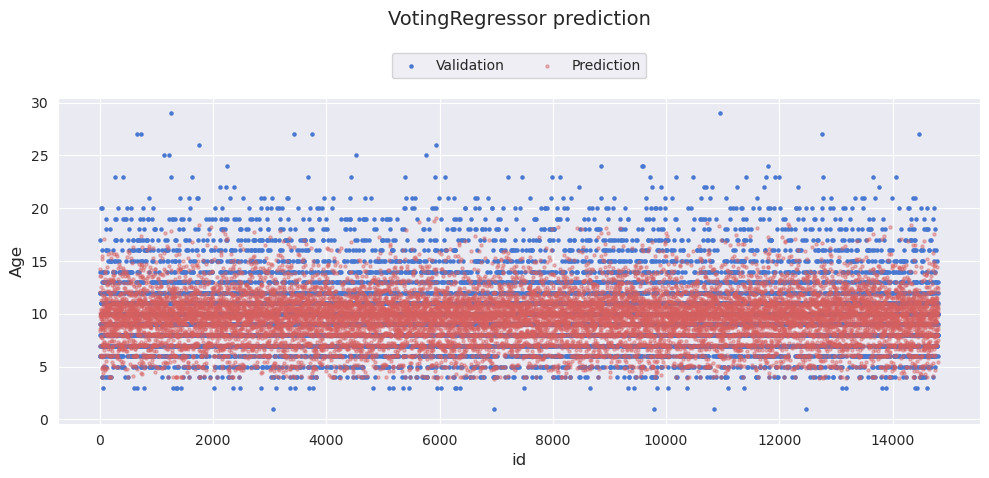

In [61]:
fig = plt.figure(figsize=(10,5))
plt.scatter([_ for _ in range(len(X_val))], y_val, color="C0", label="Validation", s=5)
plt.scatter([_ for _ in range(len(X_val))], y_pred, color="C3", label="Prediction", s=5, alpha=0.4)

plt.xlabel("id")
plt.ylabel("Age")
plt.title("VotingRegressor prediction", y=1.2)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc="center", ncols=2)

fig.tight_layout()
plt.show()

The model does well in predicting the age of younger crabs, but it is difficult to predict it for older ones.

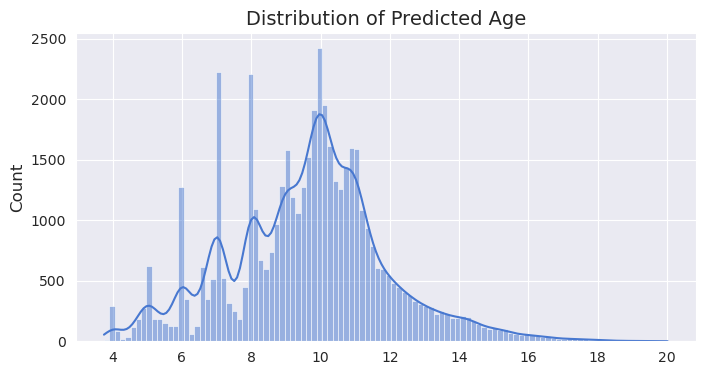

In [62]:
# Predict on the test set
y_test_pred = voting_reg.predict(X_test)

# Visualize prediction results
sns.histplot(y_test_pred, kde=True)
plt.title("Distribution of Predicted Age")

plt.show()

We can see that the distribution of our predicted age is similar to the actual distribution. Also, using the VotingRegressor we were able to decrease the MAE, which is great.

In [63]:
# Prepare final submission dataframe
submission = pd.read_csv("/kaggle/input/playground-series-s3e16/sample_submission.csv")
submission["Age"] = np.round(y_test_pred).astype(int)
submission

,id,Age
0,74051,7
1,74052,8
2,74053,10
3,74054,9
4,74055,7
...,...,...
49363,123414,9
49364,123415,8
49365,123416,13
49366,123417,10


In [64]:
submission.to_csv("submission.csv", index=False)